In [ ]:

!pip install arch --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.1/985.1 kB 12.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from arch import arch_model
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import pandas as pd
import numpy as np
from arch import arch_model
from scipy.stats import chi2
from tabulate import tabulate


# Wstępne przygotowanie danych

In [ ]:
# określenie okna 2 lutniego - handel na bitcoinie otwarty jest codziennie, również w weekendy
window_size = 2 * 365

In [ ]:
data = pd.read_csv('Bitcoin_30_11_2014-15_12_2024_historical_data_coinmarketcap.csv', sep=';')

In [ ]:
# Data engineering

# Wyodrębnienie odpowiednich kolumn i przetworzenie danych
data['date'] = data['timeOpen'].str.slice(0, 10)  # Wyodrębnienie tylko daty (pierwsze 10 znaków) z kolumny timeOpen
# Konwersja cen zamknięcia ('close') na wartości numeryczne
data['close'] = pd.to_numeric(data['close'], errors='coerce')
# Sprawdzenie brakujących wartości
missing_data = data[['date', 'close']].isnull().sum()
print("Braki w danych:")
print(missing_data)

Braki w danych:
date     0
close    0
dtype: int64


In [ ]:
data = data[['date', 'close']].sort_values('date')

In [ ]:
# Obliczenie dziennych logarytmicznych stóp zwrotu
data['log_return'] = (data['close'] / data['close'].shift(1)).apply(np.log) * 100
data['date'] = pd.to_datetime(data['date'])

**powyzej stosujemy rescaling ponieważ pomaga to w uniknięciu problemów zbieżności algorytmu optymalizacji, poprawia stabilność modeli GARCH, gdyż nasze log return mają małą skalę.**


In [ ]:
# Przygotowanie danych do analizy i uniknięcie błędu IndexError
analysis_end_date = pd.Timestamp("2024-11-30")
data_for_analysis = data[data['date'] <= analysis_end_date].copy()
data_extended = data  # Zawiera wszystkie dane, w tym grudniowe, do wyznaczenia next_return

<ipython-input-15-0440a4bc9e07>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tick_dates = data_for_analysis[data_for_analysis['date'].dt.month == 11][data_for_analysis['date'].dt.day == 30]['date']


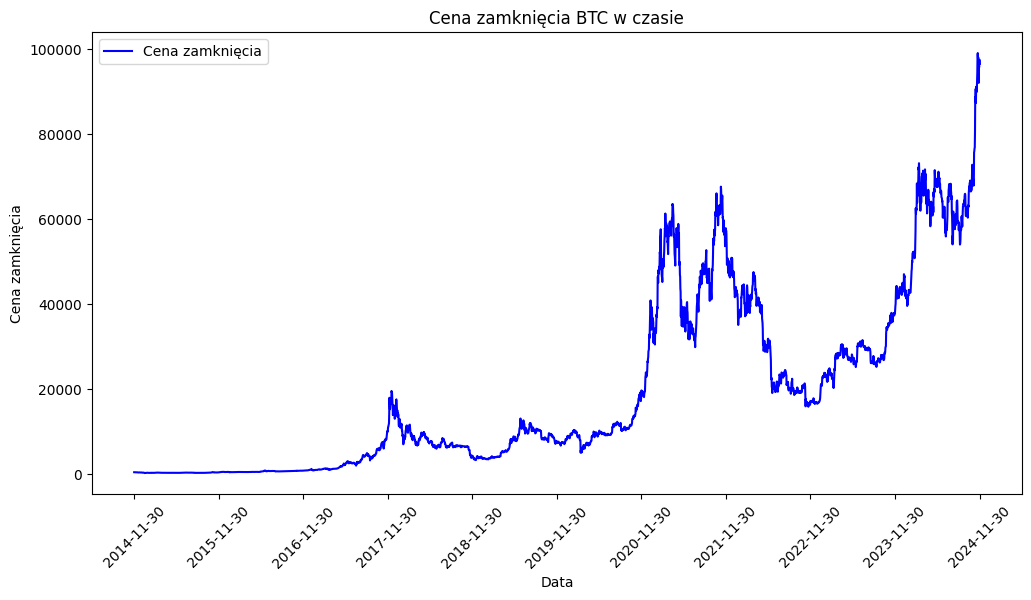

In [ ]:
#filtracja dat do 30 listopad w celu oznaczenia osi

tick_dates = data_for_analysis[data_for_analysis['date'].dt.month == 11][data_for_analysis['date'].dt.day == 30]['date']
# Wizualizacja danych cen zamknięcia i stóp zwrotu
plt.figure(figsize=(12, 6))
plt.plot(data_for_analysis['date'], data_for_analysis['close'], label='Cena zamknięcia', color='blue')
plt.title('Cena zamknięcia BTC w czasie')
plt.xlabel('Data')
plt.ylabel('Cena zamknięcia')
plt.xticks(tick_dates, labels=tick_dates.dt.strftime('%Y-%m-%d'), rotation=45)
plt.legend()
plt.show()

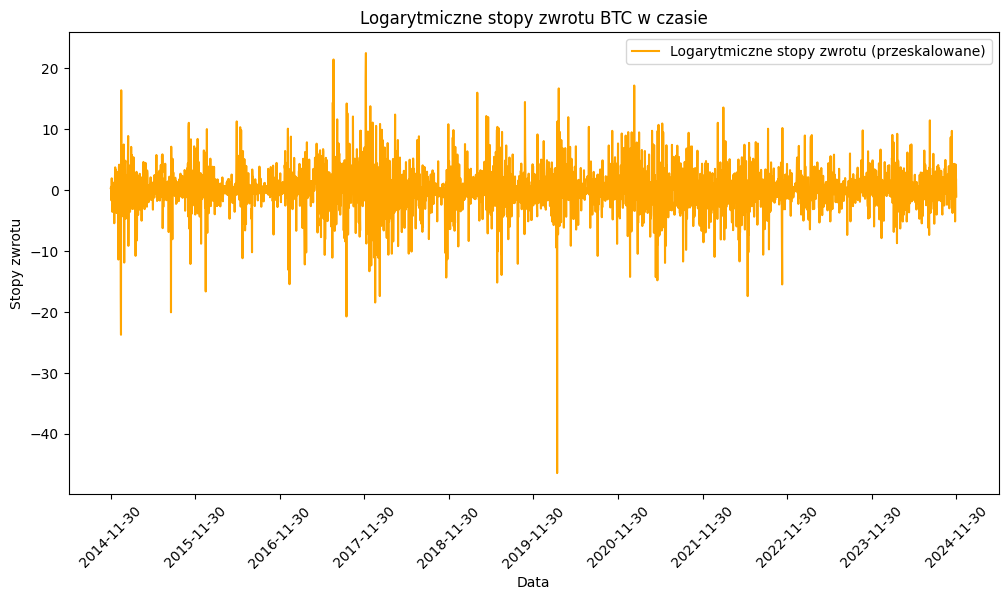

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(data_for_analysis['date'], data_for_analysis['log_return'], label='Logarytmiczne stopy zwrotu (przeskalowane)', color='orange')
plt.title('Logarytmiczne stopy zwrotu BTC w czasie')
plt.xlabel('Data')
plt.ylabel('Stopy zwrotu')
plt.xticks(tick_dates, labels=tick_dates.dt.strftime('%Y-%m-%d'), rotation=45)
plt.legend()
plt.show()

# Definiowanie funkcji metody historycznej i wariancji-kowariancji

In [ ]:
def historical_var(returns, alpha):
    return -np.percentile(returns, alpha * 100)

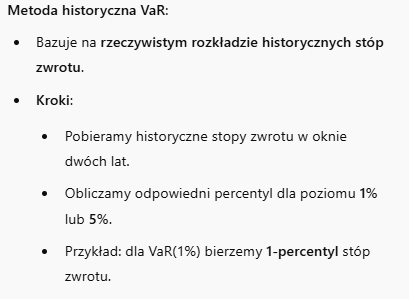

In [ ]:
def variance_covariance_var(mean, std, alpha):
    z = {0.01: 2.33, 0.05: 1.645}  # Wartości krytyczne dla 1% i 5%
    return -(mean + z[alpha] * std)

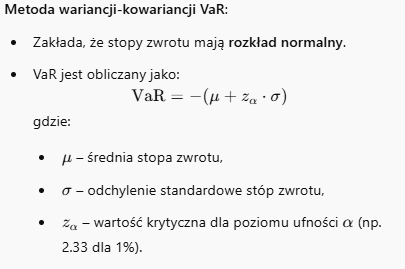

Test Kupca

In [ ]:
def kupiec_test(n, x, p):
    if x == 0 or x == n:
        return np.nan, 1.0
    p_hat = x / n
    lr_uc = -2 * (np.log((p**x) * ((1 - p)**(n - x))) - np.log((p_hat**x) * ((1 - p_hat)**(n - x))))
    p_value = 1 - chi2.cdf(lr_uc, 1)
    return lr_uc, p_value

Test Christoffersen

In [ ]:
def christoffersen_test(exceedances):
    exceedances = np.array(exceedances)
    T01 = np.sum((exceedances[:-1] == 0) & (exceedances[1:] == 1))
    T11 = np.sum((exceedances[:-1] == 1) & (exceedances[1:] == 1))
    T00 = np.sum((exceedances[:-1] == 0) & (exceedances[1:] == 0))
    T10 = np.sum((exceedances[:-1] == 1) & (exceedances[1:] == 0))

    if (T00 + T01 == 0) or (T10 + T11 == 0):
        return np.nan, 1.0

    p01 = T01 / (T00 + T01)
    p11 = T11 / (T10 + T11)
    p = (T01 + T11) / (T00 + T01 + T10 + T11)

    lr_ind = -2 * (np.log((p**(T01 + T11)) * ((1 - p)**(T00 + T10))) -
                   np.log((p01**T01) * ((1 - p01)**T00) * (p11**T11) * ((1 - p11)**T10)))
    p_value = 1 - chi2.cdf(lr_ind, 1)
    return lr_ind, p_value

# GARCH

In [ ]:
# Przechowywanie wyników

var_results = []
test_results = []

results_Odrzucenia =[]


# Iteracja po przesuwanych oknach
for start in range(len(data_for_analysis) - window_size):
    # Wyodrębnienie danych dla bieżącego okna
    window_data = data_for_analysis[start : start + window_size]
    next_return_index = start + window_size  # Indeks dla next_return

    # Pobranie next_return z rozszerzonych danych, aby uniknąć błędu IndexError
    if next_return_index < len(data_extended):
        next_return = data_extended['log_return'].iloc[next_return_index]
    else:
        break
    # GARCH z rozkładem normalnym i t-Studenta
    garch_normal = arch_model(window_data['log_return'].dropna(), vol='Garch', p=1, q=1,  dist='normal').fit(disp="off")
    garch_t = arch_model(window_data['log_return'].dropna(), vol='Garch', p=1, q=1,dist='t').fit(disp="off")

    # Prognozowanie VaR
    forecast_normal = garch_normal.forecast(horizon=1)
    forecast_t = garch_t.forecast(horizon=1)

    var_1_normal = -forecast_normal.mean['h.1'].iloc[-1] - 2.33 * np.sqrt(forecast_normal.variance['h.1'].iloc[-1])
    var_5_normal = -forecast_normal.mean['h.1'].iloc[-1] - 1.645 * np.sqrt(forecast_normal.variance['h.1'].iloc[-1])

    var_1_t = -forecast_t.mean['h.1'].iloc[-1] - 2.33 * np.sqrt(forecast_t.variance['h.1'].iloc[-1])
    var_5_t = -forecast_t.mean['h.1'].iloc[-1] - 1.645 * np.sqrt(forecast_t.variance['h.1'].iloc[-1])

    # Metody historyczne i wariancji-kowariancji
    hist_var_1 = historical_var(window_data['log_return'].dropna(), 0.01)
    hist_var_5 = historical_var(window_data['log_return'].dropna(), 0.05)

    mean, std = window_data['log_return'].mean(), window_data['log_return'].std()
    varcov_var_1 = variance_covariance_var(mean, std, 0.01)
    varcov_var_5 = variance_covariance_var(mean, std, 0.05)

    # Analiza reszt
    residuals_normal = garch_normal.resid / np.sqrt(garch_normal.conditional_volatility)
    residuals_t = garch_t.resid / np.sqrt(garch_t.conditional_volatility)

    shapiro_pvalue_normal = stats.shapiro(residuals_normal.dropna()).pvalue
    jb_stat_t, jb_pvalue_t = stats.jarque_bera(residuals_t.dropna())

    # Przekroczenia VaR
    exceed_1_normal = 1 if next_return < var_1_normal else 0
    exceed_5_normal = 1 if next_return < var_5_normal else 0
    exceed_1_t = 1 if next_return < var_1_t else 0
    exceed_5_t = 1 if next_return < var_5_t else 0

    # Przekroczenia dla metody historycznej i wariancji-kowariancji
    exceed_hist_1 = 1 if next_return < hist_var_1 else 0
    exceed_hist_5 = 1 if next_return < hist_var_5 else 0
    exceed_varcov_1 = 1 if next_return < varcov_var_1 else 0
    exceed_varcov_5 = 1 if next_return < varcov_var_5 else 0

    # Zapis wyników
    results_Odrzucenia({

    })


    var_results.append({
        'start_date': data_for_analysis['date'].iloc[start],
        'end_date': data_for_analysis['date'].iloc[start + window_size - 1],
        'var_1_normal': var_1_normal, 'var_5_normal': var_5_normal,
        'var_1_t': var_1_t, 'var_5_t': var_5_t,
        'hist_var_1': hist_var_1, 'hist_var_5': hist_var_5,
        'varcov_var_1': varcov_var_1, 'varcov_var_5': varcov_var_5,
        'exceed_1_normal': exceed_1_normal, 'exceed_5_normal': exceed_5_normal,
        'exceed_1_t': exceed_1_t, 'exceed_5_t': exceed_5_t,
        'exceed_hist_1': exceed_hist_1, 'exceed_hist_5': exceed_hist_5,
        'exceed_varcov_1': exceed_varcov_1, 'exceed_varcov_5': exceed_varcov_5
    })
    test_results.append({
        'start_date': data_for_analysis['date'].iloc[start],
        'end_date': data_for_analysis['date'].iloc[start + window_size - 1],
        'shapiro_pvalue_normal': shapiro_pvalue_normal,
        'jarque_bera_pvalue_t': jb_pvalue_t
    })

# Konwersja wyników do DataFrame
var_df = pd.DataFrame(var_results)
tests_df = pd.DataFrame(test_results)

# Podsumowanie testów
print("Podsumowanie wyników testów normalności reszt:")
print(tests_df.describe())

Podsumowanie wyników testów normalności reszt:
                start_date                       end_date  \
count                 2924                           2924   
mean   2018-11-30 12:00:00  2020-11-28 12:00:00.000000256   
min    2014-11-30 00:00:00            2016-11-28 00:00:00   
25%    2016-11-29 18:00:00            2018-11-28 18:00:00   
50%    2018-11-30 12:00:00            2020-11-28 12:00:00   
75%    2020-11-30 06:00:00            2022-11-29 06:00:00   
max    2022-12-01 00:00:00            2024-11-29 00:00:00   
std                    NaN                            NaN   

       shapiro_pvalue_normal  jarque_bera_pvalue_t  
count           2.924000e+03          2.924000e+03  
mean            4.463581e-12          2.108057e-34  
min             1.129543e-27          0.000000e+00  
25%             2.252695e-24          0.000000e+00  
50%             2.776484e-16         1.286009e-157  
75%             5.496318e-14          6.009890e-59  
max             1.297514e-10    

In [ ]:
# Podsumowanie VaR
print("Podsumowanie przekroczeń i wartości VaR:")
print(var_df[['exceed_1_normal', 'exceed_5_normal', 'exceed_1_t', 'exceed_5_t', 'exceed_hist_1', 'exceed_hist_5', 'exceed_varcov_1', 'exceed_varcov_5']].sum())
print(var_df[['hist_var_1', 'hist_var_5', 'varcov_var_1', 'varcov_var_5']].describe())

Podsumowanie przekroczeń i wartości VaR:
exceed_1_normal      51
exceed_5_normal     113
exceed_1_t           41
exceed_5_t          112
exceed_hist_1      2893
exceed_hist_5      2731
exceed_varcov_1      51
exceed_varcov_5     121
dtype: int64
        hist_var_1   hist_var_5  varcov_var_1  varcov_var_5
count  2924.000000  2924.000000   2924.000000   2924.000000
mean     10.486107     5.709992     -8.850175     -6.295314
std       1.335922     1.143573      1.434226      1.030895
min       6.178225     3.420026    -11.027706     -7.851759
25%      10.208202     4.963062     -9.838716     -7.020135
50%      10.716973     5.899506     -9.073854     -6.425178
75%      11.156846     6.436789     -7.592286     -5.404367
max      12.314896     7.690499     -5.950523     -4.260474


Test Kupca oraz Chrisoffersena dla GARCH (Normlany, t-student) dla poziomu ufnosci 99% - alfa w kupcu 0,01





In [ ]:
window_size = 2 * 365
alpha_values = [0.01]
results = []

# Iteracja przez okna danych
for alpha in alpha_values:
    for start in range(len(data_for_analysis) - window_size):
        window_data = data_for_analysis.iloc[start : start + window_size]
        next_return_index = start + window_size
        if next_return_index >= len(data_for_analysis):
            break
        next_return = data_for_analysis['log_return'].iloc[next_return_index]

        # Obliczanie VaR z GARCH (Normalny)
        garch_normal = arch_model(window_data['log_return'].dropna(), vol='Garch', p=1, q=1, dist='normal').fit(disp="off")
        forecast_normal = garch_normal.forecast(horizon=1)
        var_normal = -forecast_normal.mean['h.1'].iloc[-1] - 2.33 * np.sqrt(forecast_normal.variance['h.1'].iloc[-1])

        # Obliczanie VaR z GARCH (t-Studenta)
        garch_t = arch_model(window_data['log_return'].dropna(), vol='Garch', p=1, q=1, dist='t').fit(disp="off")
        forecast_t = garch_t.forecast(horizon=1)
        var_t = -forecast_t.mean['h.1'].iloc[-1] - 2.33 * np.sqrt(forecast_t.variance['h.1'].iloc[-1])

        # Odrzuty - przekroczenie VaR
        exceedances_normal = [1 if ret < var_normal else 0 for ret in window_data['log_return'].dropna()]
        exceedances_t = [1 if ret < var_t else 0 for ret in window_data['log_return'].dropna()]

        # Wyniki dla modeli GARCH
        results.append({
            "Model": "GARCH Normalny",
            "Alpha": alpha,
            "Kupiec_stat": kupiec_test(len(exceedances_normal), sum(exceedances_normal), alpha)[0],
            "Kupiec_p": kupiec_test(len(exceedances_normal), sum(exceedances_normal), alpha)[1],
            "Christoffersen_stat": christoffersen_test(exceedances_normal)[0],
            "Christoffersen_p": christoffersen_test(exceedances_normal)[1]
        })

        results.append({
            "Model": "GARCH t-Studenta",
            "Alpha": alpha,
            "Kupiec_stat": kupiec_test(len(exceedances_t), sum(exceedances_t), alpha)[0],
            "Kupiec_p": kupiec_test(len(exceedances_t), sum(exceedances_t), alpha)[1],
            "Christoffersen_stat": christoffersen_test(exceedances_t)[0],
            "Christoffersen_p": christoffersen_test(exceedances_t)[1]
        })

# --- Podsumowanie wyników ---
def summarize_rejections(results, alpha=0.01):
    summary = {"Model": [], "Alpha": [], "Kupiec (Odrzucone)": [], "Christoffersen (Odrzucone)": []}
    models = set(res["Model"] for res in results)
    alphas = set(res["Alpha"] for res in results)

    for model in models:
        for a in alphas:
            kupiec_rejections = sum(
                1 if res["Kupiec_p"] < alpha and res["Model"] == model and res["Alpha"] == a else 0
                for res in results
            )
            christoffersen_rejections = sum(
                1 if res["Christoffersen_p"] < alpha and res["Model"] == model and res["Alpha"] == a else 0
                for res in results
            )
            summary["Model"].append(model)
            summary["Alpha"].append(a)
            summary["Kupiec (Odrzucone)"].append(kupiec_rejections)
            summary["Christoffersen (Odrzucone)"].append(christoffersen_rejections)

    return pd.DataFrame(summary)

summary_df = summarize_rejections(results)

# Wyświetlanie podsumowania w tabeli
print(tabulate(summary_df, headers="keys", tablefmt="fancy_grid", showindex=False))

╒══════════════════╤═════════╤══════════════════════╤══════════════════════════════╕
│ Model            │   Alpha │   Kupiec (Odrzucone) │   Christoffersen (Odrzucone) │
╞══════════════════╪═════════╪══════════════════════╪══════════════════════════════╡
│ GARCH Normalny   │    0.01 │                 1542 │                          103 │
├──────────────────┼─────────┼──────────────────────┼──────────────────────────────┤
│ GARCH t-Studenta │    0.01 │                 1447 │                          135 │
╘══════════════════╧═════════╧══════════════════════╧══════════════════════════════╛


Test Kupca oraz Chrisoffersena dla GARCH (Normlany, t-student) dla poziomu ufnosci 95% - alfa w kupcu 0,05



In [ ]:
window_size = 2 * 365
alpha_values = [0.05]
results = []

# Iteracja przez okna danych
for alpha in alpha_values:
    for start in range(len(data_for_analysis) - window_size):
        window_data = data_for_analysis.iloc[start : start + window_size]
        next_return_index = start + window_size
        if next_return_index >= len(data_for_analysis):
            break
        next_return = data_for_analysis['log_return'].iloc[next_return_index]

        # Obliczanie VaR z GARCH (Normalny) 0,01
        garch_normal = arch_model(window_data['log_return'].dropna(), vol='Garch', p=1, q=1, dist='normal').fit(disp="off")
        forecast_normal = garch_normal.forecast(horizon=1)
        var_normal = -forecast_normal.mean['h.1'].iloc[-1] - 1.645  * np.sqrt(forecast_normal.variance['h.1'].iloc[-1])

        # Obliczanie VaR z GARCH (t-Studenta) 0,05
        garch_t = arch_model(window_data['log_return'].dropna(), vol='Garch', p=1, q=1, dist='t').fit(disp="off")
        forecast_t = garch_t.forecast(horizon=1)
        var_t = -forecast_t.mean['h.1'].iloc[-1] - 1.645  * np.sqrt(forecast_t.variance['h.1'].iloc[-1])

        # Odrzuty - przekroczenie VaR
        exceedances_normal = [1 if ret < var_normal else 0 for ret in window_data['log_return'].dropna()]
        exceedances_t = [1 if ret < var_t else 0 for ret in window_data['log_return'].dropna()]

        # Wyniki dla modeli GARCH
        results.append({
            "Model": "GARCH Normalny",
            "Alpha": alpha,
            "Kupiec_stat": kupiec_test(len(exceedances_normal), sum(exceedances_normal), alpha)[0],
            "Kupiec_p": kupiec_test(len(exceedances_normal), sum(exceedances_normal), alpha)[1],
            "Christoffersen_stat": christoffersen_test(exceedances_normal)[0],
            "Christoffersen_p": christoffersen_test(exceedances_normal)[1]
        })

        results.append({
            "Model": "GARCH t-Studenta",
            "Alpha": alpha,
            "Kupiec_stat": kupiec_test(len(exceedances_t), sum(exceedances_t), alpha)[0],
            "Kupiec_p": kupiec_test(len(exceedances_t), sum(exceedances_t), alpha)[1],
            "Christoffersen_stat": christoffersen_test(exceedances_t)[0],
            "Christoffersen_p": christoffersen_test(exceedances_t)[1]
        })

# --- Podsumowanie wyników ---
def summarize_rejections(results, alpha=0.05):
    summary = {"Model": [], "Alpha": [], "Kupiec (Odrzucone)": [], "Christoffersen (Odrzucone)": []}
    models = set(res["Model"] for res in results)
    alphas = set(res["Alpha"] for res in results)

    for model in models:
        for a in alphas:
            kupiec_rejections = sum(
                1 if res["Kupiec_p"] < alpha and res["Model"] == model and res["Alpha"] == a else 0
                for res in results
            )
            christoffersen_rejections = sum(
                1 if res["Christoffersen_p"] < alpha and res["Model"] == model and res["Alpha"] == a else 0
                for res in results
            )
            summary["Model"].append(model)
            summary["Alpha"].append(a)
            summary["Kupiec (Odrzucone)"].append(kupiec_rejections)
            summary["Christoffersen (Odrzucone)"].append(christoffersen_rejections)

    return pd.DataFrame(summary)

summary_df = summarize_rejections(results)

# Wyświetlanie podsumowania w tabeli
print(tabulate(summary_df, headers="keys", tablefmt="fancy_grid", showindex=False))

╒══════════════════╤═════════╤══════════════════════╤══════════════════════════════╕
│ Model            │   Alpha │   Kupiec (Odrzucone) │   Christoffersen (Odrzucone) │
╞══════════════════╪═════════╪══════════════════════╪══════════════════════════════╡
│ GARCH t-Studenta │    0.05 │                 2038 │                          621 │
├──────────────────┼─────────┼──────────────────────┼──────────────────────────────┤
│ GARCH Normalny   │    0.05 │                 1771 │                          596 │
╘══════════════════╧═════════╧══════════════════════╧══════════════════════════════╛


Matoda wariacnji-kowariancji, hsitoryczna dla 95% - alfa 0,05

In [ ]:
window_size = 2 * 365
alpha_values = [0.05]
results = []


# Iteracja przez okna danych
for alpha in alpha_values:
    for start in range(len(data_for_analysis) - window_size):
        window_data = data_for_analysis.iloc[start : start + window_size]
        next_return_index = start + window_size
        if next_return_index >= len(data_for_analysis):
            break
        next_return = data_for_analysis['log_return'].iloc[next_return_index]

        # Obliczanie VaR
        hist_var = historical_var(window_data['log_return'].dropna(), 0.05)
        mean, std = window_data['log_return'].mean(), window_data['log_return'].std()
        varcov_var = variance_covariance_var(mean, std, 0.05)

        # Wyniki dla metod historycznej i wariancji-kowariancji
        exceedances_hist = [1 if ret < hist_var else 0 for ret in window_data['log_return'].dropna()]
        exceedances_varcov = [1 if ret < varcov_var else 0 for ret in window_data['log_return'].dropna()]

        results.append({
            "Model": "Metoda Historyczna",
            "Alpha": alpha,
            "Kupiec_stat": kupiec_test(len(exceedances_hist), sum(exceedances_hist), alpha)[0],
            "Kupiec_p": kupiec_test(len(exceedances_hist), sum(exceedances_hist), alpha)[1],
            "Christoffersen_stat": christoffersen_test(exceedances_hist)[0],
            "Christoffersen_p": christoffersen_test(exceedances_hist)[1]
        })

        results.append({
            "Model": "Wariancja-Kowariancja",
            "Alpha": alpha,
            "Kupiec_stat": kupiec_test(len(exceedances_varcov), sum(exceedances_varcov), alpha)[0],
            "Kupiec_p": kupiec_test(len(exceedances_varcov), sum(exceedances_varcov), alpha)[1],
            "Christoffersen_stat": christoffersen_test(exceedances_varcov)[0],
            "Christoffersen_p": christoffersen_test(exceedances_varcov)[1]
        })


# --- Podsumowanie wyników ---
def summarize_rejections(results, alpha=0.05):
    summary = {"Model": [], "Alpha": [], "Kupiec (Odrzucone)": [], "Christoffersen (Odrzucone)": []}
    models = set(res["Model"] for res in results)
    alphas = set(res["Alpha"] for res in results)

    for model in models:
        for a in alphas:
            kupiec_rejections = sum(
                1 if res["Kupiec_p"] < alpha and res["Model"] == model and res["Alpha"] == a else 0
                for res in results
            )
            christoffersen_rejections = sum(
                1 if res["Christoffersen_p"] < alpha and res["Model"] == model and res["Alpha"] == a else 0
                for res in results
            )
            summary["Model"].append(model)
            summary["Alpha"].append(a)
            summary["Kupiec (Odrzucone)"].append(kupiec_rejections)
            summary["Christoffersen (Odrzucone)"].append(christoffersen_rejections)


    return pd.DataFrame(summary)

summary_df = summarize_rejections(results)

# Wyświetlanie podsumowania w tabeli
print(tabulate(summary_df, headers="keys", tablefmt="fancy_grid", showindex=False))

<ipython-input-11-a877fb6d8522>:5: RuntimeWarning: divide by zero encountered in log
  lr_uc = -2 * (np.log((p**x) * ((1 - p)**(n - x))) - np.log((p_hat**x) * ((1 - p_hat)**(n - x))))


╒═══════════════════════╤═════════╤══════════════════════╤══════════════════════════════╕
│ Model                 │   Alpha │   Kupiec (Odrzucone) │   Christoffersen (Odrzucone) │
╞═══════════════════════╪═════════╪══════════════════════╪══════════════════════════════╡
│ Metoda Historyczna    │    0.05 │                 2924 │                          525 │
├───────────────────────┼─────────┼──────────────────────┼──────────────────────────────┤
│ Wariancja-Kowariancja │    0.05 │                  763 │                          419 │
╘═══════════════════════╧═════════╧══════════════════════╧══════════════════════════════╛


Metoda wariancji kowawiancji, hsitoryczna dla 99% - alfa =0,01

In [ ]:
window_size = 2 * 365
alpha_values = [0.01]
results = []


# Iteracja przez okna danych
for alpha in alpha_values:
    for start in range(len(data_for_analysis) - window_size):
        window_data = data_for_analysis.iloc[start : start + window_size]
        next_return_index = start + window_size
        if next_return_index >= len(data_for_analysis):
            break
        next_return = data_for_analysis['log_return'].iloc[next_return_index]

        # Obliczanie VaR
        hist_var = historical_var(window_data['log_return'].dropna(), 0.01)
        mean, std = window_data['log_return'].mean(), window_data['log_return'].std()
        varcov_var = variance_covariance_var(mean, std, 0.01)

        # Wyniki dla metod historycznej i wariancji-kowariancji
        exceedances_hist = [1 if ret < hist_var else 0 for ret in window_data['log_return'].dropna()]
        exceedances_varcov = [1 if ret < varcov_var else 0 for ret in window_data['log_return'].dropna()]

        results.append({
            "Model": "Metoda Historyczna",
            "Alpha": alpha,
            "Kupiec_stat": kupiec_test(len(exceedances_hist), sum(exceedances_hist), alpha)[0],
            "Kupiec_p": kupiec_test(len(exceedances_hist), sum(exceedances_hist), alpha)[1],
            "Christoffersen_stat": christoffersen_test(exceedances_hist)[0],
            "Christoffersen_p": christoffersen_test(exceedances_hist)[1]
        })

        results.append({
            "Model": "Wariancja-Kowariancja",
            "Alpha": alpha,
            "Kupiec_stat": kupiec_test(len(exceedances_varcov), sum(exceedances_varcov), alpha)[0],
            "Kupiec_p": kupiec_test(len(exceedances_varcov), sum(exceedances_varcov), alpha)[1],
            "Christoffersen_stat": christoffersen_test(exceedances_varcov)[0],
            "Christoffersen_p": christoffersen_test(exceedances_varcov)[1]
        })


# --- Podsumowanie wyników ---
def summarize_rejections(results, alpha=0.01):
    summary = {"Model": [], "Alpha": [], "Kupiec (Odrzucone)": [], "Christoffersen (Odrzucone)": []}
    models = set(res["Model"] for res in results)
    alphas = set(res["Alpha"] for res in results)

    for model in models:
        for a in alphas:
            kupiec_rejections = sum(
                1 if res["Kupiec_p"] < alpha and res["Model"] == model and res["Alpha"] == a else 0
                for res in results
            )
            christoffersen_rejections = sum(
                1 if res["Christoffersen_p"] < alpha and res["Model"] == model and res["Alpha"] == a else 0
                for res in results
            )
            summary["Model"].append(model)
            summary["Alpha"].append(a)
            summary["Kupiec (Odrzucone)"].append(kupiec_rejections)
            summary["Christoffersen (Odrzucone)"].append(christoffersen_rejections)


    return pd.DataFrame(summary)

summary_df = summarize_rejections(results)

# Wyświetlanie podsumowania w tabeli
print(tabulate(summary_df, headers="keys", tablefmt="fancy_grid", showindex=False))

<ipython-input-12-a877fb6d8522>:5: RuntimeWarning: divide by zero encountered in log
  lr_uc = -2 * (np.log((p**x) * ((1 - p)**(n - x))) - np.log((p_hat**x) * ((1 - p_hat)**(n - x))))


╒═══════════════════════╤═════════╤══════════════════════╤══════════════════════════════╕
│ Model                 │   Alpha │   Kupiec (Odrzucone) │   Christoffersen (Odrzucone) │
╞═══════════════════════╪═════════╪══════════════════════╪══════════════════════════════╡
│ Wariancja-Kowariancja │    0.01 │                  815 │                          234 │
├───────────────────────┼─────────┼──────────────────────┼──────────────────────────────┤
│ Metoda Historyczna    │    0.01 │                 2924 │                            0 │
╘═══════════════════════╧═════════╧══════════════════════╧══════════════════════════════╛


# GJR-GARCH

In [ ]:
# Przechowywanie wyników

var_results = []
test_results = []


# Iteracja po przesuwanych oknach
for start in range(len(data_for_analysis) - window_size):
    # Wyodrębnienie danych dla bieżącego okna
    window_data = data_for_analysis[start : start + window_size]
    next_return_index = start + window_size  # Indeks dla next_return

    # Pobranie next_return z rozszerzonych danych, aby uniknąć błędu IndexError
    if next_return_index < len(data_extended):
        next_return = data_extended['log_return'].iloc[next_return_index]
    else:
        break
    # GJR-GARCH z rozkładem normalnym i t-Studenta
    gjr_garch_normal = arch_model(window_data['log_return'].dropna(), vol='Garch', p=1, q=1, o=1, dist='normal').fit(disp="off")
    gjr_garch_t = arch_model(window_data['log_return'].dropna(), vol='Garch', p=1, q=1, o=1, dist='t').fit(disp="off")

    # Prognozowanie VaR
    forecast_normal = gjr_garch_normal.forecast(horizon=1)
    forecast_t = gjr_garch_t.forecast(horizon=1)

    var_1_normal = -forecast_normal.mean['h.1'].iloc[-1] - 2.33 * np.sqrt(forecast_normal.variance['h.1'].iloc[-1])
    var_5_normal = -forecast_normal.mean['h.1'].iloc[-1] - 1.645 * np.sqrt(forecast_normal.variance['h.1'].iloc[-1])

    var_1_t = -forecast_t.mean['h.1'].iloc[-1] - 2.33 * np.sqrt(forecast_t.variance['h.1'].iloc[-1])
    var_5_t = -forecast_t.mean['h.1'].iloc[-1] - 1.645 * np.sqrt(forecast_t.variance['h.1'].iloc[-1])

    # Metody historyczne i wariancji-kowariancji
    hist_var_1 = historical_var(window_data['log_return'].dropna(), 0.01)
    hist_var_5 = historical_var(window_data['log_return'].dropna(), 0.05)

    mean, std = window_data['log_return'].mean(), window_data['log_return'].std()
    varcov_var_1 = variance_covariance_var(mean, std, 0.01)
    varcov_var_5 = variance_covariance_var(mean, std, 0.05)

    # Analiza reszt
    residuals_normal = gjr_garch_normal.resid / np.sqrt(gjr_garch_normal.conditional_volatility)
    residuals_t = gjr_garch_t.resid / np.sqrt(gjr_garch_t.conditional_volatility)

    shapiro_pvalue_normal = stats.shapiro(residuals_normal.dropna()).pvalue
    jb_stat_t, jb_pvalue_t = stats.jarque_bera(residuals_t.dropna())

    # Przekroczenia VaR
    exceed_1_normal = 1 if next_return < var_1_normal else 0
    exceed_5_normal = 1 if next_return < var_5_normal else 0
    exceed_1_t = 1 if next_return < var_1_t else 0
    exceed_5_t = 1 if next_return < var_5_t else 0

    # Przekroczenia dla metody historycznej i wariancji-kowariancji
    exceed_hist_1 = 1 if next_return < hist_var_1 else 0
    exceed_hist_5 = 1 if next_return < hist_var_5 else 0
    exceed_varcov_1 = 1 if next_return < varcov_var_1 else 0
    exceed_varcov_5 = 1 if next_return < varcov_var_5 else 0

    # Zapis wyników
    var_results.append({
        'start_date': data_for_analysis['date'].iloc[start],
        'end_date': data_for_analysis['date'].iloc[start + window_size - 1],
        'var_1_normal': var_1_normal, 'var_5_normal': var_5_normal,
        'var_1_t': var_1_t, 'var_5_t': var_5_t,
        'hist_var_1': hist_var_1, 'hist_var_5': hist_var_5,
        'varcov_var_1': varcov_var_1, 'varcov_var_5': varcov_var_5,
        'exceed_1_normal': exceed_1_normal, 'exceed_5_normal': exceed_5_normal,
        'exceed_1_t': exceed_1_t, 'exceed_5_t': exceed_5_t,
        'exceed_hist_1': exceed_hist_1, 'exceed_hist_5': exceed_hist_5,
        'exceed_varcov_1': exceed_varcov_1, 'exceed_varcov_5': exceed_varcov_5
    })
    test_results.append({
        'start_date': data_for_analysis['date'].iloc[start],
        'end_date': data_for_analysis['date'].iloc[start + window_size - 1],
        'shapiro_pvalue_normal': shapiro_pvalue_normal,
        'jarque_bera_pvalue_t': jb_pvalue_t
    })

# Konwersja wyników do DataFrame
var_df = pd.DataFrame(var_results)
tests_df = pd.DataFrame(test_results)

# Podsumowanie testów
print("Podsumowanie wyników testów normalności reszt:")
print(tests_df.describe())

Podsumowanie wyników testów normalności reszt:
                start_date                       end_date  \
count                 2924                           2924   
mean   2018-11-30 12:00:00  2020-11-28 12:00:00.000000256   
min    2014-11-30 00:00:00            2016-11-28 00:00:00   
25%    2016-11-29 18:00:00            2018-11-28 18:00:00   
50%    2018-11-30 12:00:00            2020-11-28 12:00:00   
75%    2020-11-30 06:00:00            2022-11-29 06:00:00   
max    2022-12-01 00:00:00            2024-11-29 00:00:00   
std                    NaN                            NaN   

       shapiro_pvalue_normal  jarque_bera_pvalue_t  
count           2.924000e+03          2.924000e+03  
mean            5.378464e-12          1.220609e-34  
min             1.366105e-26          0.000000e+00  
25%             4.928941e-23          0.000000e+00  
50%             3.853727e-16         4.094692e-157  
75%             1.212180e-13          1.471344e-57  
max             1.491054e-10    

In [ ]:
# Podsumowanie VaR
print("Podsumowanie przekroczeń i wartości VaR:")
print(var_df[['exceed_1_normal', 'exceed_5_normal', 'exceed_1_t', 'exceed_5_t', 'exceed_hist_1', 'exceed_hist_5', 'exceed_varcov_1', 'exceed_varcov_5']].sum())
print(var_df[['hist_var_1', 'hist_var_5', 'varcov_var_1', 'varcov_var_5']].describe())

Podsumowanie przekroczeń i wartości VaR:
exceed_1_normal      53
exceed_5_normal     118
exceed_1_t           45
exceed_5_t          117
exceed_hist_1      2893
exceed_hist_5      2731
exceed_varcov_1      51
exceed_varcov_5     121
dtype: int64
        hist_var_1   hist_var_5  varcov_var_1  varcov_var_5
count  2924.000000  2924.000000   2924.000000   2924.000000
mean     10.486107     5.709992     -8.850175     -6.295314
std       1.335922     1.143573      1.434226      1.030895
min       6.178225     3.420026    -11.027706     -7.851759
25%      10.208202     4.963062     -9.838716     -7.020135
50%      10.716973     5.899506     -9.073854     -6.425178
75%      11.156846     6.436789     -7.592286     -5.404367
max      12.314896     7.690499     -5.950523     -4.260474


Test Kupca oraz Chrisoffersena dla GJR-GARCH (Normlany, t-student) dla poziomu ufnosci 99% - alfa w kupcu 0,01

In [ ]:
window_size = 2 * 365
alpha_values = [0.01]
results = []

# Iteracja przez okna danych
for alpha in alpha_values:
    for start in range(len(data_for_analysis) - window_size):
        window_data = data_for_analysis.iloc[start : start + window_size]
        next_return_index = start + window_size
        if next_return_index >= len(data_for_analysis):
            break
        next_return = data_for_analysis['log_return'].iloc[next_return_index]

        # Obliczanie VaR z GARCH (Normalny)
        gjr_garch_normal = arch_model(window_data['log_return'].dropna(), vol='Garch', p=1, q=1, o=1, dist='normal').fit(disp="off")
        forecast_normal = gjr_garch_normal.forecast(horizon=1)
        var_normal = -forecast_normal.mean['h.1'].iloc[-1] - 2.33 * np.sqrt(forecast_normal.variance['h.1'].iloc[-1])

        # Obliczanie VaR z GARCH (t-Studenta)
        gjr_garch_t = arch_model(window_data['log_return'].dropna(), vol='Garch', p=1, q=1, o=1, dist='t').fit(disp="off")
        forecast_t = gjr_garch_t.forecast(horizon=1)
        var_t = -forecast_t.mean['h.1'].iloc[-1] - 2.33 * np.sqrt(forecast_t.variance['h.1'].iloc[-1])

        # Odrzuty - przekroczenie VaR
        exceedances_normal = [1 if ret < var_normal else 0 for ret in window_data['log_return'].dropna()]
        exceedances_t = [1 if ret < var_t else 0 for ret in window_data['log_return'].dropna()]

        # Wyniki dla modeli GARCH
        results.append({
            "Model": "GJR-GARCH Normalny",
            "Alpha": alpha,
            "Kupiec_stat": kupiec_test(len(exceedances_normal), sum(exceedances_normal), alpha)[0],
            "Kupiec_p": kupiec_test(len(exceedances_normal), sum(exceedances_normal), alpha)[1],
            "Christoffersen_stat": christoffersen_test(exceedances_normal)[0],
            "Christoffersen_p": christoffersen_test(exceedances_normal)[1]
        })

        results.append({
            "Model": "GJR-GARCH t-Studenta",
            "Alpha": alpha,
            "Kupiec_stat": kupiec_test(len(exceedances_t), sum(exceedances_t), alpha)[0],
            "Kupiec_p": kupiec_test(len(exceedances_t), sum(exceedances_t), alpha)[1],
            "Christoffersen_stat": christoffersen_test(exceedances_t)[0],
            "Christoffersen_p": christoffersen_test(exceedances_t)[1]
        })

# --- Podsumowanie wyników ---
def summarize_rejections(results, alpha=0.01):
    summary = {"Model": [], "Alpha": [], "Kupiec (Odrzucone)": [], "Christoffersen (Odrzucone)": []}
    models = set(res["Model"] for res in results)
    alphas = set(res["Alpha"] for res in results)

    for model in models:
        for a in alphas:
            kupiec_rejections = sum(
                1 if res["Kupiec_p"] < alpha and res["Model"] == model and res["Alpha"] == a else 0
                for res in results
            )
            christoffersen_rejections = sum(
                1 if res["Christoffersen_p"] < alpha and res["Model"] == model and res["Alpha"] == a else 0
                for res in results
            )
            summary["Model"].append(model)
            summary["Alpha"].append(a)
            summary["Kupiec (Odrzucone)"].append(kupiec_rejections)
            summary["Christoffersen (Odrzucone)"].append(christoffersen_rejections)

    return pd.DataFrame(summary)

summary_df = summarize_rejections(results)

# Wyświetlanie podsumowania w tabeli
print(tabulate(summary_df, headers="keys", tablefmt="fancy_grid", showindex=False))

╒══════════════════════╤═════════╤══════════════════════╤══════════════════════════════╕
│ Model                │   Alpha │   Kupiec (Odrzucone) │   Christoffersen (Odrzucone) │
╞══════════════════════╪═════════╪══════════════════════╪══════════════════════════════╡
│ GJR-GARCH Normalny   │    0.01 │                 1643 │                          114 │
├──────────────────────┼─────────┼──────────────────────┼──────────────────────────────┤
│ GJR-GARCH t-Studenta │    0.01 │                 1446 │                          129 │
╘══════════════════════╧═════════╧══════════════════════╧══════════════════════════════╛


Test Kupca oraz Chrisoffersena dla GJR-GARCH (Normlany, t-student) dla poziomu ufnosci 95% - alfa w kupcu 0,05

In [ ]:
window_size = 2 * 365
alpha_values = [0.05]
results = []

# Iteracja przez okna danych
for alpha in alpha_values:
    for start in range(len(data_for_analysis) - window_size):
        window_data = data_for_analysis.iloc[start : start + window_size]
        next_return_index = start + window_size
        if next_return_index >= len(data_for_analysis):
            break
        next_return = data_for_analysis['log_return'].iloc[next_return_index]

        # Obliczanie VaR z GARCH (Normalny)
        gjr_garch_normal = arch_model(window_data['log_return'].dropna(), vol='Garch', p=1, q=1, o=1, dist='normal').fit(disp="off")
        forecast_normal = gjr_garch_normal.forecast(horizon=1)
        var_normal = -forecast_normal.mean['h.1'].iloc[-1] - 1.645 * np.sqrt(forecast_normal.variance['h.1'].iloc[-1])

        # Obliczanie VaR z GARCH (t-Studenta)
        gjr_garch_t = arch_model(window_data['log_return'].dropna(), vol='Garch', p=1, q=1, o=1, dist='t').fit(disp="off")
        forecast_t = gjr_garch_t.forecast(horizon=1)
        var_t = -forecast_t.mean['h.1'].iloc[-1] - 1.645* np.sqrt(forecast_t.variance['h.1'].iloc[-1])

        # Odrzuty - przekroczenie VaR
        exceedances_normal = [1 if ret < var_normal else 0 for ret in window_data['log_return'].dropna()]
        exceedances_t = [1 if ret < var_t else 0 for ret in window_data['log_return'].dropna()]

        # Wyniki dla modeli GARCH
        results.append({
            "Model": "GJR-GARCH Normalny",
            "Alpha": alpha,
            "Kupiec_stat": kupiec_test(len(exceedances_normal), sum(exceedances_normal), alpha)[0],
            "Kupiec_p": kupiec_test(len(exceedances_normal), sum(exceedances_normal), alpha)[1],
            "Christoffersen_stat": christoffersen_test(exceedances_normal)[0],
            "Christoffersen_p": christoffersen_test(exceedances_normal)[1]
        })

        results.append({
            "Model": "GJR-GARCH t-Studenta",
            "Alpha": alpha,
            "Kupiec_stat": kupiec_test(len(exceedances_t), sum(exceedances_t), alpha)[0],
            "Kupiec_p": kupiec_test(len(exceedances_t), sum(exceedances_t), alpha)[1],
            "Christoffersen_stat": christoffersen_test(exceedances_t)[0],
            "Christoffersen_p": christoffersen_test(exceedances_t)[1]
        })

# --- Podsumowanie wyników ---
def summarize_rejections(results, alpha=0.05):
    summary = {"Model": [], "Alpha": [], "Kupiec (Odrzucone)": [], "Christoffersen (Odrzucone)": []}
    models = set(res["Model"] for res in results)
    alphas = set(res["Alpha"] for res in results)

    for model in models:
        for a in alphas:
            kupiec_rejections = sum(
                1 if res["Kupiec_p"] < alpha and res["Model"] == model and res["Alpha"] == a else 0
                for res in results
            )
            christoffersen_rejections = sum(
                1 if res["Christoffersen_p"] < alpha and res["Model"] == model and res["Alpha"] == a else 0
                for res in results
            )
            summary["Model"].append(model)
            summary["Alpha"].append(a)
            summary["Kupiec (Odrzucone)"].append(kupiec_rejections)
            summary["Christoffersen (Odrzucone)"].append(christoffersen_rejections)

    return pd.DataFrame(summary)

summary_df = summarize_rejections(results)

# Wyświetlanie podsumowania w tabeli
print(tabulate(summary_df, headers="keys", tablefmt="fancy_grid", showindex=False))

╒══════════════════════╤═════════╤══════════════════════╤══════════════════════════════╕
│ Model                │   Alpha │   Kupiec (Odrzucone) │   Christoffersen (Odrzucone) │
╞══════════════════════╪═════════╪══════════════════════╪══════════════════════════════╡
│ GJR-GARCH Normalny   │    0.05 │                 1746 │                          597 │
├──────────────────────┼─────────┼──────────────────────┼──────────────────────────────┤
│ GJR-GARCH t-Studenta │    0.05 │                 2047 │                          641 │
╘══════════════════════╧═════════╧══════════════════════╧══════════════════════════════╛


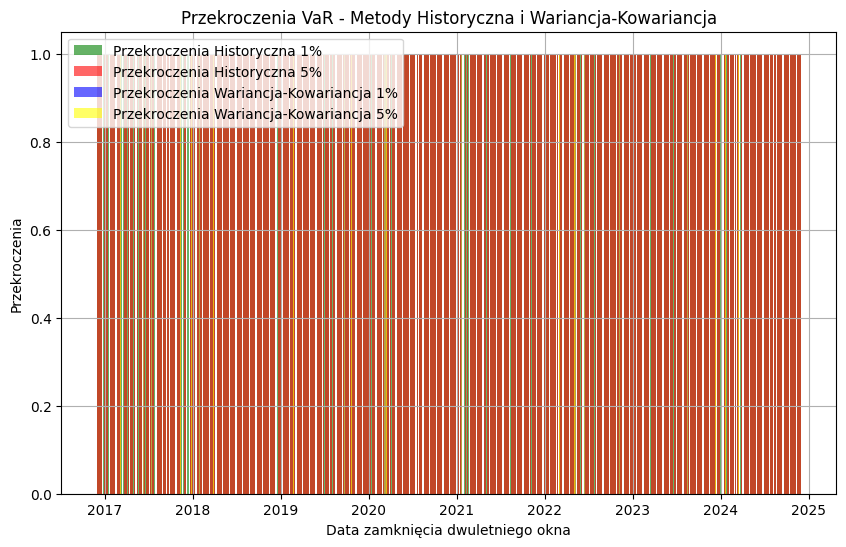

In [ ]:
# Wizualizacja przekroczeń dla metody historycznej i wariancji-kowariancji
plt.figure(figsize=(10, 6))
plt.bar(var_df['end_date'], var_df['exceed_hist_1'], label='Przekroczenia Historyczna 1%', color='green', alpha=0.6)
plt.bar(var_df['end_date'], var_df['exceed_hist_5'], label='Przekroczenia Historyczna 5%', color='red', alpha=0.6)
plt.bar(var_df['end_date'], var_df['exceed_varcov_1'], label='Przekroczenia Wariancja-Kowariancja 1%', color='blue', alpha=0.6)
plt.bar(var_df['end_date'], var_df['exceed_varcov_5'], label='Przekroczenia Wariancja-Kowariancja 5%', color='yellow', alpha=0.6)
plt.title('Przekroczenia VaR - Metody Historyczna i Wariancja-Kowariancja')
plt.xlabel('Data zamknięcia dwuletniego okna')
plt.ylabel('Przekroczenia')
plt.legend()
plt.grid()
plt.show()



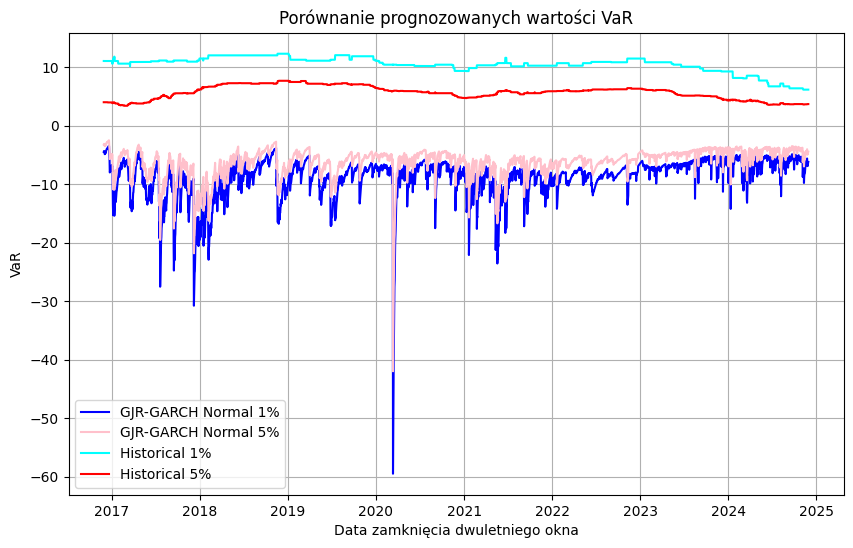

In [ ]:
# Wizualizacja wyników VaR
plt.figure(figsize=(10, 6))
plt.plot(var_df['end_date'], var_df['var_1_normal'], label='GJR-GARCH Normal 1%', color='blue')
plt.plot(var_df['end_date'], var_df['var_5_normal'], label='GJR-GARCH Normal 5%', color='pink')
plt.plot(var_df['end_date'], var_df['hist_var_1'], label='Historical 1%', color='cyan')
plt.plot(var_df['end_date'], var_df['hist_var_5'], label='Historical 5%', color='red')
plt.title('Porównanie prognozowanych wartości VaR')
plt.xlabel('Data zamknięcia dwuletniego okna')
plt.ylabel('VaR')
plt.legend()
plt.grid()
plt.show()

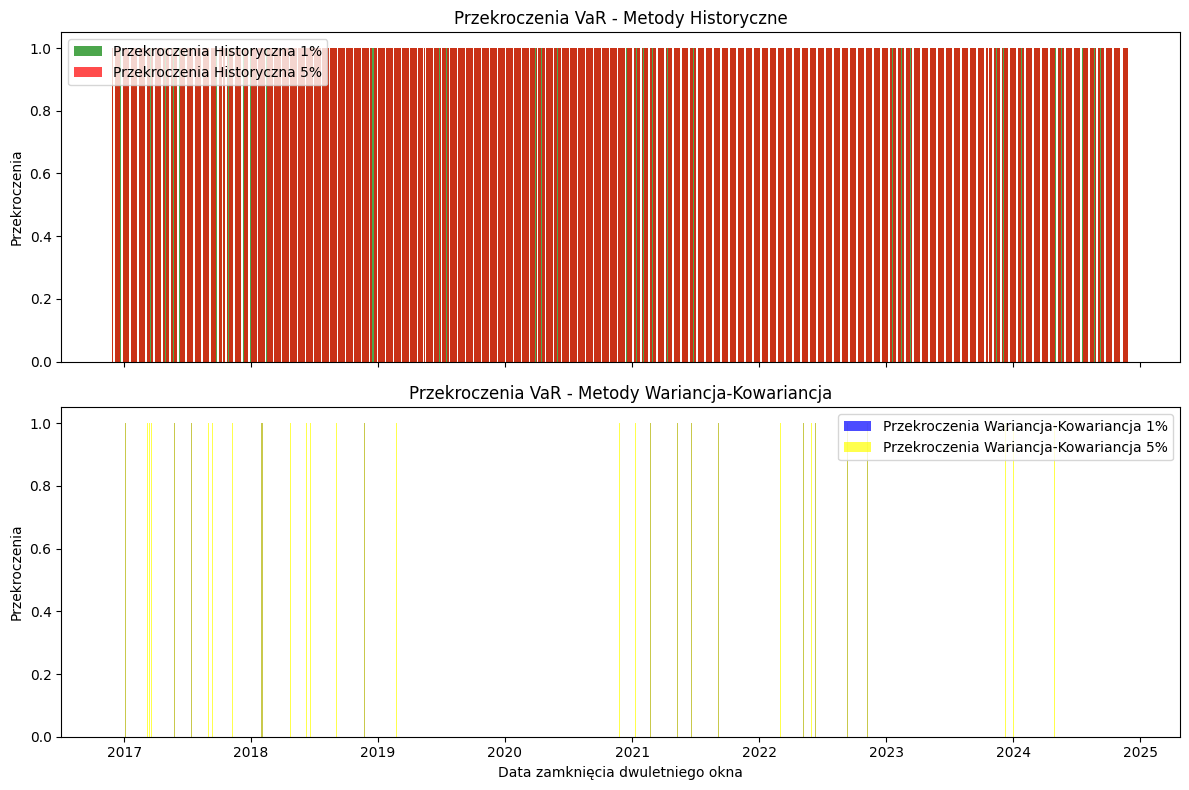

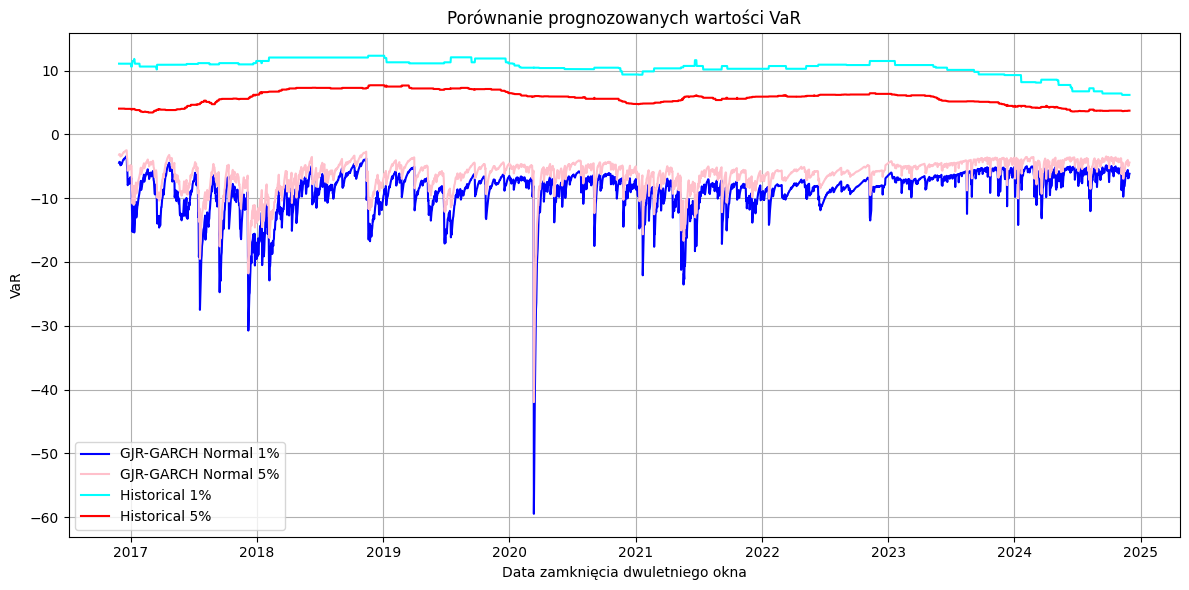

In [ ]:
# Wizualizacja przekroczeń VaR dla metod historycznej i wariancji-kowariancji
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Przekroczenia dla metod historycznej
axes[0].bar(var_df['end_date'], var_df['exceed_hist_1'], label='Przekroczenia Historyczna 1%', color='green', alpha=0.7)
axes[0].bar(var_df['end_date'], var_df['exceed_hist_5'], label='Przekroczenia Historyczna 5%', color='red', alpha=0.7)
axes[0].set_title("Przekroczenia VaR - Metody Historyczne")
axes[0].legend()
axes[0].set_ylabel("Przekroczenia")

# Przekroczenia dla metod wariancji-kowariancji
axes[1].bar(var_df['end_date'], var_df['exceed_varcov_1'], label='Przekroczenia Wariancja-Kowariancja 1%', color='blue', alpha=0.7)
axes[1].bar(var_df['end_date'], var_df['exceed_varcov_5'], label='Przekroczenia Wariancja-Kowariancja 5%', color='yellow', alpha=0.7)
axes[1].set_title("Przekroczenia VaR - Metody Wariancja-Kowariancja")
axes[1].legend()
axes[1].set_ylabel("Przekroczenia")
axes[1].set_xlabel("Data zamknięcia dwuletniego okna")

plt.tight_layout()
plt.show()

# Porównanie prognozowanych wartości VaR
plt.figure(figsize=(12, 6))
plt.plot(var_df['end_date'], var_df['var_1_normal'], label='GJR-GARCH Normal 1%', color='blue')
plt.plot(var_df['end_date'], var_df['var_5_normal'], label='GJR-GARCH Normal 5%', color='pink')
plt.plot(var_df['end_date'], var_df['hist_var_1'], label='Historical 1%', color='cyan')
plt.plot(var_df['end_date'], var_df['hist_var_5'], label='Historical 5%', color='red')
plt.title("Porównanie prognozowanych wartości VaR")
plt.xlabel("Data zamknięcia dwuletniego okna")
plt.ylabel("VaR")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


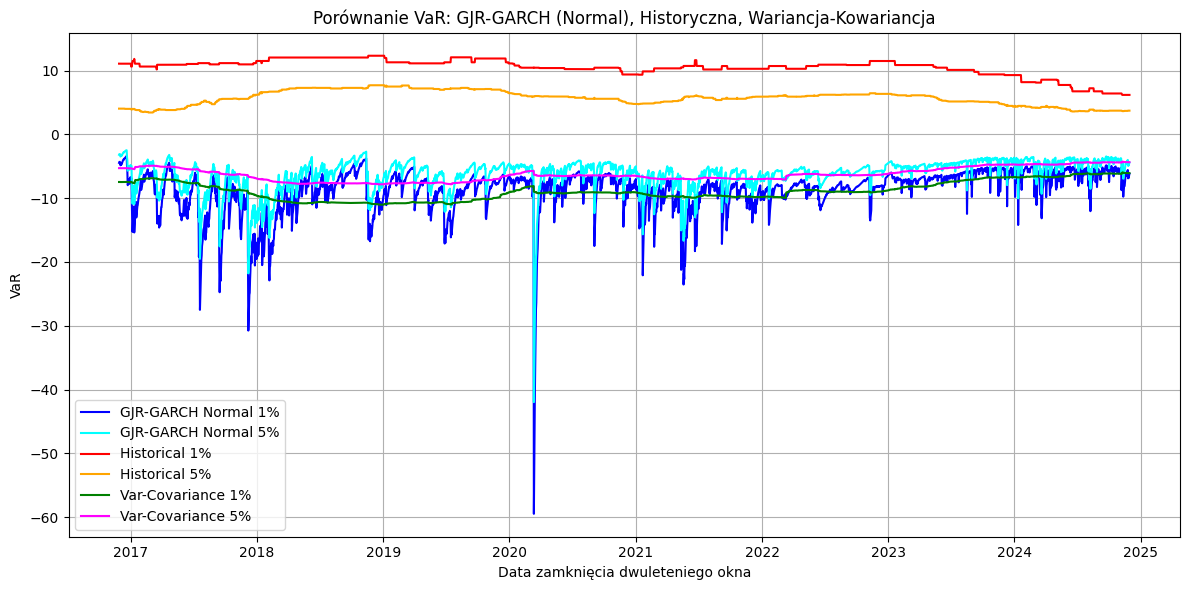

In [ ]:
# Wizualizacja porównania GJR-GARCH (Normal) z Historyczną i Wariancją-Kowariancją
plt.figure(figsize=(12, 6))
plt.plot(var_df['end_date'], var_df['var_1_normal'], label='GJR-GARCH Normal 1%', color='blue')
plt.plot(var_df['end_date'], var_df['var_5_normal'], label='GJR-GARCH Normal 5%', color='cyan')
plt.plot(var_df['end_date'], var_df['hist_var_1'], label='Historical 1%', color='red')
plt.plot(var_df['end_date'], var_df['hist_var_5'], label='Historical 5%', color='orange')
plt.plot(var_df['end_date'], var_df['varcov_var_1'], label='Var-Covariance 1%', color='green')
plt.plot(var_df['end_date'], var_df['varcov_var_5'], label='Var-Covariance 5%', color='magenta')
plt.title("Porównanie VaR: GJR-GARCH (Normal), Historyczna, Wariancja-Kowariancja")
plt.xlabel("Data zamknięcia dwuleteniego okna")
plt.ylabel("VaR")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

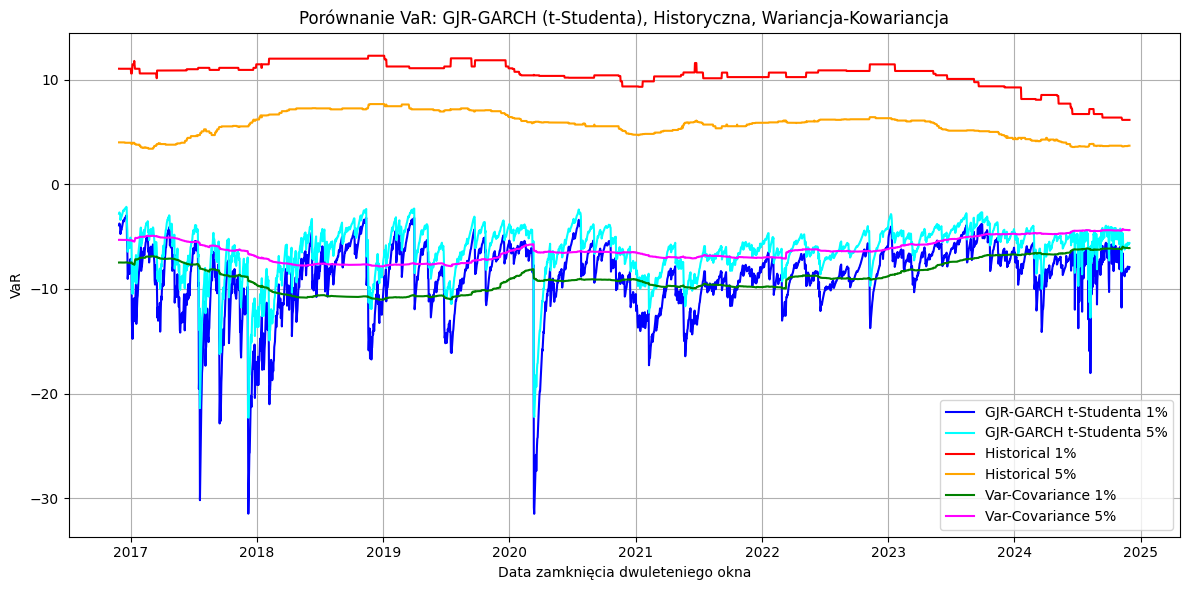

In [ ]:
# Wizualizacja porównania GJR-GARCH (t-Studenta) z Historyczną i Wariancją-Kowariancją
plt.figure(figsize=(12, 6))
plt.plot(var_df['end_date'], var_df['var_1_t'], label='GJR-GARCH t-Studenta 1%', color='blue')
plt.plot(var_df['end_date'], var_df['var_5_t'], label='GJR-GARCH t-Studenta 5%', color='cyan')
plt.plot(var_df['end_date'], var_df['hist_var_1'], label='Historical 1%', color='red')
plt.plot(var_df['end_date'], var_df['hist_var_5'], label='Historical 5%', color='orange')
plt.plot(var_df['end_date'], var_df['varcov_var_1'], label='Var-Covariance 1%', color='green')
plt.plot(var_df['end_date'], var_df['varcov_var_5'], label='Var-Covariance 5%', color='magenta')
plt.title("Porównanie VaR: GJR-GARCH (t-Studenta), Historyczna, Wariancja-Kowariancja")
plt.xlabel("Data zamknięcia dwuleteniego okna")
plt.ylabel("VaR")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

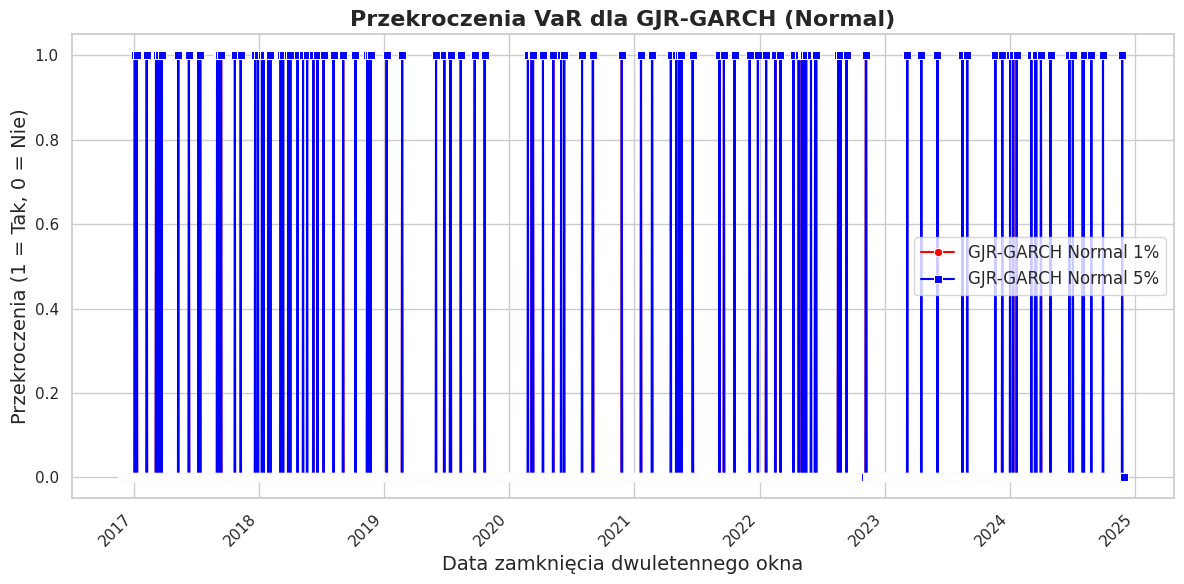

In [ ]:
# Wykres 1: Normal
plt.figure(figsize=(12, 6))
sns.lineplot(
    x='end_date', y='exceed_1_normal', data=var_df,
    label='GJR-GARCH Normal 1%', color='red', marker='o'
)
sns.lineplot(
    x='end_date', y='exceed_5_normal', data=var_df,
    label='GJR-GARCH Normal 5%', color='blue', marker='s'
)
plt.title("Przekroczenia VaR dla GJR-GARCH (Normal)", fontsize=16, fontweight='bold')
plt.xlabel("Data zamknięcia dwuletennego okna", fontsize=14)
plt.ylabel("Przekroczenia (1 = Tak, 0 = Nie)", fontsize=14)
plt.legend(fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

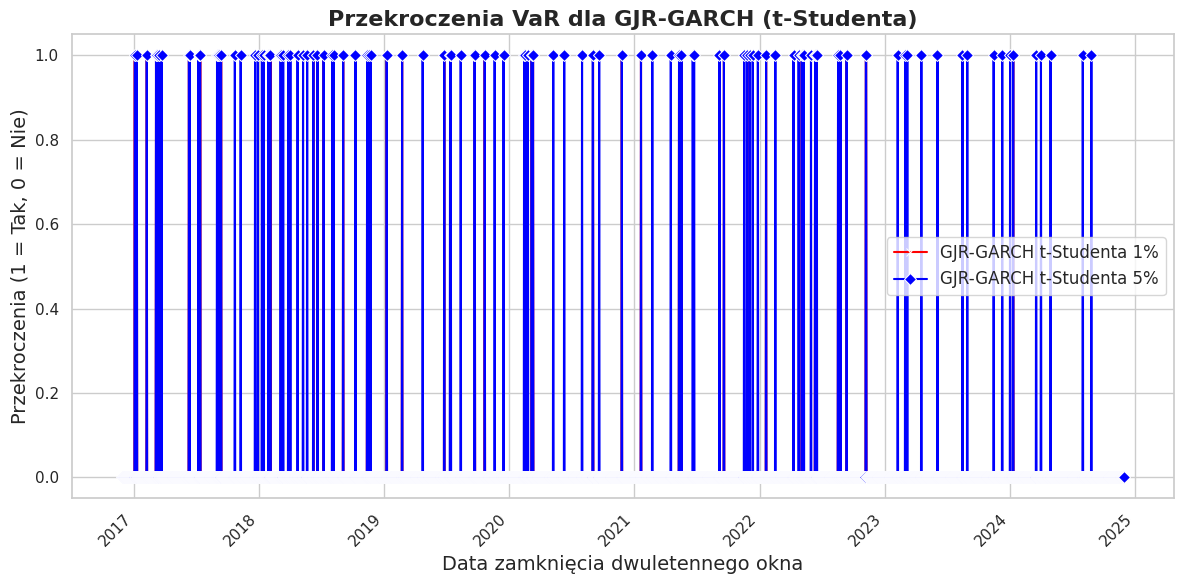

In [ ]:
# Wykres 2: t-Studenta
plt.figure(figsize=(12, 6))
sns.lineplot(
    x='end_date', y='exceed_1_t', data=var_df,
    label='GJR-GARCH t-Studenta 1%', color='red', marker='x'
)
sns.lineplot(
    x='end_date', y='exceed_5_t', data=var_df,
    label='GJR-GARCH t-Studenta 5%', color='blue', marker='D'
)
plt.title("Przekroczenia VaR dla GJR-GARCH (t-Studenta)", fontsize=16, fontweight='bold')
plt.xlabel("Data zamknięcia dwuletennego okna", fontsize=14)
plt.ylabel("Przekroczenia (1 = Tak, 0 = Nie)", fontsize=14)
plt.legend(fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# EGARCH

In [ ]:
# Przechowywanie wyników

var_results = []
test_results = []


# Iteracja po przesuwanych oknach
for start in range(len(data_for_analysis) - window_size):
    # Wyodrębnienie danych dla bieżącego okna
    window_data = data_for_analysis[start : start + window_size]
    next_return_index = start + window_size  # Indeks dla next_return

    # Pobranie next_return z rozszerzonych danych, aby uniknąć błędu IndexError
    if next_return_index < len(data_extended):
        next_return = data_extended['log_return'].iloc[next_return_index]
    else:
        break
    # E-GARCH z rozkładem normalnym i t-Studenta
    e_garch_normal = arch_model(window_data['log_return'].dropna(), vol='EGarch', p=1, q=1, dist='normal').fit(disp="off")
    e_garch_t = arch_model(window_data['log_return'].dropna(), vol='EGarch', p=1, q=1, dist='t').fit(disp="off")

    # Prognozowanie VaR
    forecast_normal = e_garch_normal.forecast(horizon=1)
    forecast_t = e_garch_t.forecast(horizon=1)

    var_1_normal = -forecast_normal.mean['h.1'].iloc[-1] - 2.33 * np.sqrt(forecast_normal.variance['h.1'].iloc[-1])
    var_5_normal = -forecast_normal.mean['h.1'].iloc[-1] - 1.645 * np.sqrt(forecast_normal.variance['h.1'].iloc[-1])

    var_1_t = -forecast_t.mean['h.1'].iloc[-1] - 2.33 * np.sqrt(forecast_t.variance['h.1'].iloc[-1])
    var_5_t = -forecast_t.mean['h.1'].iloc[-1] - 1.645 * np.sqrt(forecast_t.variance['h.1'].iloc[-1])

    # Metody historyczne i wariancji-kowariancji
    hist_var_1 = historical_var(window_data['log_return'].dropna(), 0.01)
    hist_var_5 = historical_var(window_data['log_return'].dropna(), 0.05)

    mean, std = window_data['log_return'].mean(), window_data['log_return'].std()
    varcov_var_1 = variance_covariance_var(mean, std, 0.01)
    varcov_var_5 = variance_covariance_var(mean, std, 0.05)

    # Analiza reszt
    residuals_normal = e_garch_normal.resid / np.sqrt(e_garch_normal.conditional_volatility)
    residuals_t = e_garch_t.resid / np.sqrt(e_garch_t.conditional_volatility)

    shapiro_pvalue_normal = stats.shapiro(residuals_normal.dropna()).pvalue
    jb_stat_t, jb_pvalue_t = stats.jarque_bera(residuals_t.dropna())

    # Przekroczenia VaR
    exceed_1_normal = 1 if next_return < var_1_normal else 0
    exceed_5_normal = 1 if next_return < var_5_normal else 0
    exceed_1_t = 1 if next_return < var_1_t else 0
    exceed_5_t = 1 if next_return < var_5_t else 0

    # Przekroczenia dla metody historycznej i wariancji-kowariancji
    exceed_hist_1 = 1 if next_return < hist_var_1 else 0
    exceed_hist_5 = 1 if next_return < hist_var_5 else 0
    exceed_varcov_1 = 1 if next_return < varcov_var_1 else 0
    exceed_varcov_5 = 1 if next_return < varcov_var_5 else 0

    # Zapis wyników
    var_results.append({
        'start_date': data_for_analysis['date'].iloc[start],
        'end_date': data_for_analysis['date'].iloc[start + window_size - 1],
        'var_1_normal': var_1_normal, 'var_5_normal': var_5_normal,
        'var_1_t': var_1_t, 'var_5_t': var_5_t,
        'hist_var_1': hist_var_1, 'hist_var_5': hist_var_5,
        'varcov_var_1': varcov_var_1, 'varcov_var_5': varcov_var_5,
        'exceed_1_normal': exceed_1_normal, 'exceed_5_normal': exceed_5_normal,
        'exceed_1_t': exceed_1_t, 'exceed_5_t': exceed_5_t,
        'exceed_hist_1': exceed_hist_1, 'exceed_hist_5': exceed_hist_5,
        'exceed_varcov_1': exceed_varcov_1, 'exceed_varcov_5': exceed_varcov_5
    })
    test_results.append({
        'start_date': data_for_analysis['date'].iloc[start],
        'end_date': data_for_analysis['date'].iloc[start + window_size - 1],
        'shapiro_pvalue_normal': shapiro_pvalue_normal,
        'jarque_bera_pvalue_t': jb_pvalue_t
    })

# Konwersja wyników do DataFrame
var_df = pd.DataFrame(var_results)
tests_df = pd.DataFrame(test_results)

# Podsumowanie testów
print("Podsumowanie wyników testów normalności reszt:")
print(tests_df.describe())

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Podsumowanie wyników testów normalności reszt:
                start_date                       end_date  \
count                 2924                           2924   
mean   2018-11-30 12:00:00  2020-11-28 12:00:00.000000256   
min    2014-11-30 00:00:00            2016-11-28 00:00:00   
25%    2016-11-29 18:00:00            2018-11-28 18:00:00   
50%    2018-11-30 12:00:00            2020-11-28 12:00:00   
75%    2020-11-30 06:00:00            2022-11-29 06:00:00   
max    2022-12-01 00:00:00            2024-11-29 00:00:00   
std                    NaN                            NaN   

       shapiro_pvalue_normal  jarque_bera_pvalue_t  
count           2.924000e+03          2.924000e+03  
mean            5.230429e-12          5.950916e-33  
min             4.086421e-28          0.000000e+00  
25%             2.191609e-24          0.000000e+00  
50%             3.199258e-16         1.871845e-168  
75%             5.833340e-14          2.705818e-65  
max             1.735677e-10    

Podsumowanie dla VaR

In [ ]:
# Podsumowanie VaR
print("Podsumowanie przekroczeń i wartości VaR:")
print(var_df[['exceed_1_normal', 'exceed_5_normal', 'exceed_1_t', 'exceed_5_t', 'exceed_hist_1', 'exceed_hist_5', 'exceed_varcov_1', 'exceed_varcov_5']].sum())
print(var_df[['hist_var_1', 'hist_var_5', 'varcov_var_1', 'varcov_var_5']].describe())

Podsumowanie przekroczeń i wartości VaR:
exceed_1_normal      47
exceed_5_normal     105
exceed_1_t           29
exceed_5_t           67
exceed_hist_1      2893
exceed_hist_5      2731
exceed_varcov_1      51
exceed_varcov_5     121
dtype: int64
        hist_var_1   hist_var_5  varcov_var_1  varcov_var_5
count  2924.000000  2924.000000   2924.000000   2924.000000
mean     10.486107     5.709992     -8.850175     -6.295314
std       1.335922     1.143573      1.434226      1.030895
min       6.178225     3.420026    -11.027706     -7.851759
25%      10.208202     4.963062     -9.838716     -7.020135
50%      10.716973     5.899506     -9.073854     -6.425178
75%      11.156846     6.436789     -7.592286     -5.404367
max      12.314896     7.690499     -5.950523     -4.260474


Test Kupca oraz Chrisoffersena dla EGARCH (Normlany, t-student) dla poziomu ufnosci 99% - alfa w kupcu 0,01


In [ ]:
window_size = 2 * 365
alpha_values = [0.01]
results = []

# Iteracja przez okna danych
for alpha in alpha_values:
    for start in range(len(data_for_analysis) - window_size):
        window_data = data_for_analysis.iloc[start : start + window_size]
        next_return_index = start + window_size
        if next_return_index >= len(data_for_analysis):
            break
        next_return = data_for_analysis['log_return'].iloc[next_return_index]

        # Obliczanie VaR z GARCH (Normalny)
        egarch_normal = arch_model(window_data['log_return'].dropna(), vol='EGarch', p=1, q=1, dist='normal').fit(disp="off")
        forecast_normal = egarch_normal.forecast(horizon=1)
        var_normal = -forecast_normal.mean['h.1'].iloc[-1] - 2.33 * np.sqrt(forecast_normal.variance['h.1'].iloc[-1])

        # Obliczanie VaR z GARCH (t-Studenta)
        egarch_t = arch_model(window_data['log_return'].dropna(), vol='EGarch', p=1, q=1, dist='t').fit(disp="off")
        forecast_t = egarch_t.forecast(horizon=1)
        var_t = -forecast_t.mean['h.1'].iloc[-1] - 2.33 * np.sqrt(forecast_t.variance['h.1'].iloc[-1])

        # Odrzuty - przekroczenie VaR
        exceedances_normal = [1 if ret < var_normal else 0 for ret in window_data['log_return'].dropna()]
        exceedances_t = [1 if ret < var_t else 0 for ret in window_data['log_return'].dropna()]

        # Wyniki dla modeli GARCH
        results.append({
            "Model": "E-GARCH Normalny",
            "Alpha": alpha,
            "Kupiec_stat": kupiec_test(len(exceedances_normal), sum(exceedances_normal), alpha)[0],
            "Kupiec_p": kupiec_test(len(exceedances_normal), sum(exceedances_normal), alpha)[1],
            "Christoffersen_stat": christoffersen_test(exceedances_normal)[0],
            "Christoffersen_p": christoffersen_test(exceedances_normal)[1]
        })

        results.append({
            "Model": "E-GARCH t-Studenta",
            "Alpha": alpha,
            "Kupiec_stat": kupiec_test(len(exceedances_t), sum(exceedances_t), alpha)[0],
            "Kupiec_p": kupiec_test(len(exceedances_t), sum(exceedances_t), alpha)[1],
            "Christoffersen_stat": christoffersen_test(exceedances_t)[0],
            "Christoffersen_p": christoffersen_test(exceedances_t)[1]
        })

# --- Podsumowanie wyników ---
def summarize_rejections(results, alpha=0.01):
    summary = {"Model": [], "Alpha": [], "Kupiec (Odrzucone)": [], "Christoffersen (Odrzucone)": []}
    models = set(res["Model"] for res in results)
    alphas = set(res["Alpha"] for res in results)

    for model in models:
        for a in alphas:
            kupiec_rejections = sum(
                1 if res["Kupiec_p"] < alpha and res["Model"] == model and res["Alpha"] == a else 0
                for res in results
            )
            christoffersen_rejections = sum(
                1 if res["Christoffersen_p"] < alpha and res["Model"] == model and res["Alpha"] == a else 0
                for res in results
            )
            summary["Model"].append(model)
            summary["Alpha"].append(a)
            summary["Kupiec (Odrzucone)"].append(kupiec_rejections)
            summary["Christoffersen (Odrzucone)"].append(christoffersen_rejections)

    return pd.DataFrame(summary)

summary_df = summarize_rejections(results)

# Wyświetlanie podsumowania w tabeli
print(tabulate(summary_df, headers="keys", tablefmt="fancy_grid", showindex=False))

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


╒════════════════════╤═════════╤══════════════════════╤══════════════════════════════╕
│ Model              │   Alpha │   Kupiec (Odrzucone) │   Christoffersen (Odrzucone) │
╞════════════════════╪═════════╪══════════════════════╪══════════════════════════════╡
│ E-GARCH Normalny   │    0.01 │                 1486 │                          125 │
├────────────────────┼─────────┼──────────────────────┼──────────────────────────────┤
│ E-GARCH t-Studenta │    0.01 │                 1207 │                           91 │
╘════════════════════╧═════════╧══════════════════════╧══════════════════════════════╛


Test Kupca oraz Chrisoffersena dla EGARCH (Normlany, t-student) dla poziomu ufnosci 95% - alfa w kupcu 0,05


In [ ]:
window_size = 2 * 365
alpha_values = [0.05]
results = []

# Iteracja przez okna danych
for alpha in alpha_values:
    for start in range(len(data_for_analysis) - window_size):
        window_data = data_for_analysis.iloc[start : start + window_size]
        next_return_index = start + window_size
        if next_return_index >= len(data_for_analysis):
            break
        next_return = data_for_analysis['log_return'].iloc[next_return_index]

        # Obliczanie VaR z GARCH (Normalny) 0,01
        egarch_normal = arch_model(window_data['log_return'].dropna(), vol='EGarch', p=1, q=1, dist='normal').fit(disp="off")
        forecast_normal = egarch_normal.forecast(horizon=1)
        var_normal = -forecast_normal.mean['h.1'].iloc[-1] - 1.645  * np.sqrt(forecast_normal.variance['h.1'].iloc[-1])

        # Obliczanie VaR z GARCH (t-Studenta) 0,05
        egarch_t = arch_model(window_data['log_return'].dropna(), vol='EGarch', p=1, q=1, dist='t').fit(disp="off")
        forecast_t = egarch_t.forecast(horizon=1)
        var_t = -forecast_t.mean['h.1'].iloc[-1] - 1.645  * np.sqrt(forecast_t.variance['h.1'].iloc[-1])

        # Odrzuty - przekroczenie VaR
        exceedances_normal = [1 if ret < var_normal else 0 for ret in window_data['log_return'].dropna()]
        exceedances_t = [1 if ret < var_t else 0 for ret in window_data['log_return'].dropna()]

        # Wyniki dla modeli GARCH
        results.append({
            "Model": "E-GARCH Normalny",
            "Alpha": alpha,
            "Kupiec_stat": kupiec_test(len(exceedances_normal), sum(exceedances_normal), alpha)[0],
            "Kupiec_p": kupiec_test(len(exceedances_normal), sum(exceedances_normal), alpha)[1],
            "Christoffersen_stat": christoffersen_test(exceedances_normal)[0],
            "Christoffersen_p": christoffersen_test(exceedances_normal)[1]
        })

        results.append({
            "Model": "E-GARCH t-Studenta",
            "Alpha": alpha,
            "Kupiec_stat": kupiec_test(len(exceedances_t), sum(exceedances_t), alpha)[0],
            "Kupiec_p": kupiec_test(len(exceedances_t), sum(exceedances_t), alpha)[1],
            "Christoffersen_stat": christoffersen_test(exceedances_t)[0],
            "Christoffersen_p": christoffersen_test(exceedances_t)[1]
        })

# --- Podsumowanie wyników ---
def summarize_rejections(results, alpha=0.05):
    summary = {"Model": [], "Alpha": [], "Kupiec (Odrzucone)": [], "Christoffersen (Odrzucone)": []}
    models = set(res["Model"] for res in results)
    alphas = set(res["Alpha"] for res in results)

    for model in models:
        for a in alphas:
            kupiec_rejections = sum(
                1 if res["Kupiec_p"] < alpha and res["Model"] == model and res["Alpha"] == a else 0
                for res in results
            )
            christoffersen_rejections = sum(
                1 if res["Christoffersen_p"] < alpha and res["Model"] == model and res["Alpha"] == a else 0
                for res in results
            )
            summary["Model"].append(model)
            summary["Alpha"].append(a)
            summary["Kupiec (Odrzucone)"].append(kupiec_rejections)
            summary["Christoffersen (Odrzucone)"].append(christoffersen_rejections)

    return pd.DataFrame(summary)

summary_df = summarize_rejections(results)

# Wyświetlanie podsumowania w tabeli
print(tabulate(summary_df, headers="keys", tablefmt="fancy_grid", showindex=False))

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


╒════════════════════╤═════════╤══════════════════════╤══════════════════════════════╕
│ Model              │   Alpha │   Kupiec (Odrzucone) │   Christoffersen (Odrzucone) │
╞════════════════════╪═════════╪══════════════════════╪══════════════════════════════╡
│ E-GARCH Normalny   │    0.05 │                 1889 │                          578 │
├────────────────────┼─────────┼──────────────────────┼──────────────────────────────┤
│ E-GARCH t-Studenta │    0.05 │                 2256 │                          384 │
╘════════════════════╧═════════╧══════════════════════╧══════════════════════════════╛
